# Implementing Locality Sensitive Hashing from scratch

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

In this assignment, you will

- Implement the LSH algorithm for approximate nearest neighbor search
- Examine the accuracy for different documents by comparing against brute force search, and also contrast runtimes
- Explore the role of the algorithm’s tuning parameters in the accuracy of the method

In [1]:
import numpy as np                                             # dense matrices
import pandas as pd
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

Load in the dataset

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki['id'] = wiki.index

In [3]:
wiki.tail()

,URI,name,text,id
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...,59066
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...,59067
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...,59068
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...,59069
59070,<http://dbpedia.org/resource/Fawaz_Damrah>,Fawaz Damrah,fawaz mohammed damrah arabic fawwz damra was t...,59070


Extract TF-IDF vectors

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
print np.shape(wiki)
print np.shape(corpus)

(59071, 4)
(59071, 547979)


word-to-index mapping

In [6]:
import json
with open('people_wiki_map_index_to_word.json') as map_index_to_word_file:
    map_index_to_word = json.load(map_index_to_word_file)

In [7]:
print len(map_index_to_word.viewkeys())
print len(map_index_to_word.viewvalues())

547979
547979


Train an LSH model.

We will build a popular variant of LSH known as random binary projection, which approximates cosine distance

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [8]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [9]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print generate_random_vectors(num_vector=3, dim=5)

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [10]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print random_vectors.shape

(547979, 16)


In [11]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print doc.dot(random_vectors[:, 0]) >= 0 # True if positive sign; False if negative sign
print doc.dot(random_vectors[:, 1]) >= 0 # True if positive sign; False if negative sign

[ True]
[ True]


In [12]:
print doc.dot(random_vectors) >= 0 # should return an array of 16 True/False bits
print np.array(doc.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [13]:
print corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]


In [14]:
print corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


In [15]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print index_bits
print powers_of_two           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print index_bits.dot(powers_of_two)

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [16]:
index_bits = corpus.dot(random_vectors) >= 0
index_ints = index_bits.dot(powers_of_two)
print index_ints

[50917 36265 19365 ..., 52983 27589 41449]


1) Compute the integer bin indices. This step is already completed.

2) For each document in the dataset, do the following:

- Get the integer bin index for the document.
- Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
- Add the document id to the end of the list.

In [17]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [data_index] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        else: # YOUR CODE HERE
            values = table[bin_index]
            values.append(data_index)
            table[bin_index] = values

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

Checkpoint

In [18]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


# What is the document id of Barack Obama's article?

In [19]:
print wiki[wiki['name'] == 'Barack Obama']

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text     id  
35817  barack hussein obama ii brk husen bm born augu...  35817  


# Which bin contains Barack Obama's article? Enter its integer index

In [20]:
random_vectors = model['random_vectors']
bo_data = corpus[35817]
bin_index_bits_bo = (bo_data.dot(random_vectors) >= 0)
bin_indices_bo = bin_index_bits_bo.dot(powers_of_two)
print bin_indices_bo

[50194]


In [21]:
print table[50194]

[21426, 35817, 39426, 50261, 53937]


# Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

In [22]:
print wiki[wiki['name'] == 'Barack Obama']
print wiki[wiki['name'] == 'Joe Biden']

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text     id  
35817  barack hussein obama ii brk husen bm born augu...  35817  
                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text     id  
24478  joseph robinette joe biden jr dosf rbnt badn b...  24478  


In [23]:
bo_data = corpus[35817]
bin_index_bits_bo = np.array(bo_data.dot(random_vectors) >= 0, dtype=int)
print "Obama:", bin_index_bits_bo

jb_data = corpus[24478]
bin_index_bits_jb = np.array(jb_data.dot(random_vectors) >= 0, dtype=int)
print "Biden:", bin_index_bits_jb

Obama: [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
Biden: [[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]]


Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [24]:
print wiki[wiki['name'] == 'Wynn Normington Hugh-Jones']

                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text     id  
22745  sir wynn normington hughjones kb sometimes kno...  22745  


In [25]:
bo_data = corpus[35817]
bin_index_bits_bo = np.array(bo_data.dot(random_vectors) >= 0, dtype=int)
print "Obama:", bin_index_bits_bo

wnhj_data = corpus[22745]
bin_index_bits_wnhj = np.array(wnhj_data.dot(random_vectors) >= 0, dtype=int)
print "Jones:", bin_index_bits_wnhj

Obama: [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
Jones: [[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]]


How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [26]:
print wiki['name'][21426], np.array(corpus[21426].dot(random_vectors) >= 0, dtype=int)
print wiki['name'][35817], np.array(corpus[35817].dot(random_vectors) >= 0, dtype=int)
print wiki['name'][39426], np.array(corpus[39426].dot(random_vectors) >= 0, dtype=int)
print wiki['name'][50261], np.array(corpus[50261].dot(random_vectors) >= 0, dtype=int)
print wiki['name'][53937], np.array(corpus[53937].dot(random_vectors) >= 0, dtype=int)

Mark Boulware [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
Barack Obama [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
John Wells (politician) [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
Francis Longstaff [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]
Madurai T. Srinivasan [[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]]


In [27]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))

doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[wiki.id==doc_id].name,
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - 21426    Mark Boulware
Name: name, dtype: object: 0.950867
Barack Obama - 39426    John Wells (politician)
Name: name, dtype: object: 0.975966
Barack Obama - 50261    Francis Longstaff
Name: name, dtype: object: 0.978256
Barack Obama - 53937    Madurai T. Srinivasan
Name: name, dtype: object: 0.993092


Query the LSH model

In [28]:
from itertools import combinations

num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [29]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not alternate_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

Checkpoint

In [30]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print candidate_set
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
set([35817, 21426, 53937, 39426, 50261])
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [31]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'
print candidate_set

Passed test
set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547, 23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676, 19699, 2804, 20347])


Now we have a function that can return all the candidates from neighboring bins. 

Next we write a function to collect all candidates and compute their true distance to the query

In [32]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id':list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.nsmallest(k, 'distance'), len(candidate_set)

Checkpoint

In [33]:
nn, candidate_set_len = query(corpus[35817,:], model, k=10, max_search_radius=3)
print candidate_set_len
print nn

727
        id      distance
375  35817 -6.661338e-16
701  24478  7.031387e-01
261  56008  8.568481e-01
125  37199  8.746687e-01
515  40353  8.900342e-01
401   9267  8.983772e-01
225  55909  8.993404e-01
366   9165  9.009210e-01
226  57958  9.030033e-01
264  49872  9.095328e-01


To identify the documents, it's helpful to join this table with the Wikipedia table:

In [34]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print result.merge(wiki[['id', 'name']], on='id').sort_values(by='distance', ascending=True)

      id      distance                     name
0  35817 -6.661338e-16             Barack Obama
1  24478  7.031387e-01                Joe Biden
2  56008  8.568481e-01            Nathan Cullen
3  37199  8.746687e-01  Barry Sullivan (lawyer)
4  40353  8.900342e-01            Neil MacBride
5   9267  8.983772e-01      Vikramaditya Khanna
6  55909  8.993404e-01              Herman Cain
7   9165  9.009210e-01     Raymond F. Clevenger
8  57958  9.030033e-01        Michael J. Malbin
9  49872  9.095328e-01            Lowell Barron


Experimenting with your LSH implementation

# What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

In [35]:
import time

num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print 'Radius:', max_search_radius
    # Display 10 nearest neighbors, along with document ID and name
    print result.merge(wiki[['id', 'name']], on='id').sort_values(by='distance', ascending=True)
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
      id      distance                     name
0  35817 -6.661338e-16             Barack Obama
1  21426  9.508668e-01            Mark Boulware
2  39426  9.759660e-01  John Wells (politician)
3  50261  9.782562e-01        Francis Longstaff
4  53937  9.930921e-01    Madurai T. Srinivasan
Radius: 1
      id      distance                                   name
0  35817 -6.661338e-16                           Barack Obama
1  41631  9.474595e-01                            Binayak Sen
2  21426  9.508668e-01                          Mark Boulware
3  33243  9.517658e-01                        Janice Lachance
4  33996  9.608591e-01                            Rufus Black
5  28444  9.610806e-01                       John Paul Phelan
6  20347  9.741296e-01                        Gianni De Fraja
7  39426  9.759660e-01                John Wells (politician)
8  34547  9.782149e-01  Nathan Murphy (Australian politician)
9  50261  9.782562e-01                      Francis Longstaff
Radius: 2


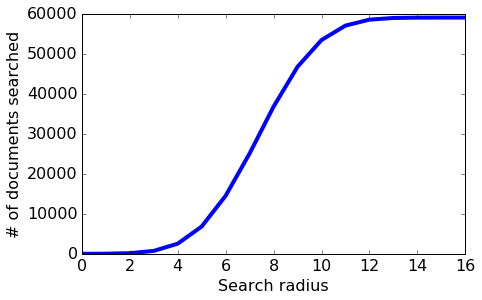

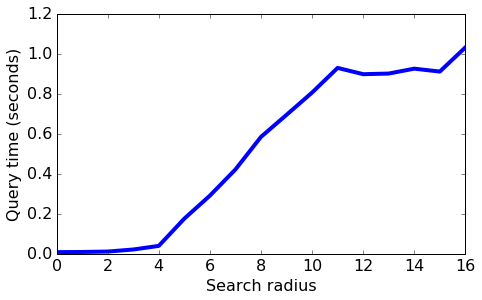

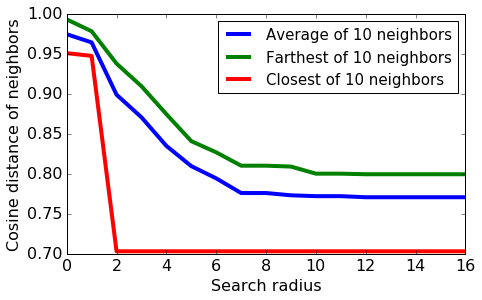

In [36]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

# Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?

In [37]:
for max_search_radius in xrange(5):
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    print max_search_radius, np.round(np.average(result.distance),2), num_candidates

0 0.78 5
1 0.87 27
2 0.81 153
3 0.78 727
4 0.75 2531


Quality metrics for neighbors

In [38]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.nsmallest(k, 'distance')

In [39]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


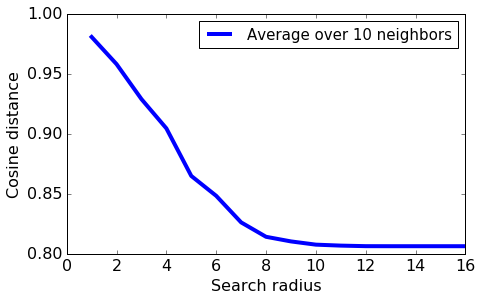

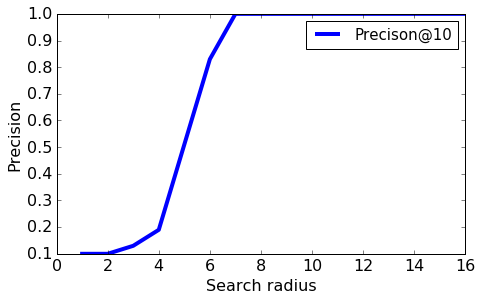

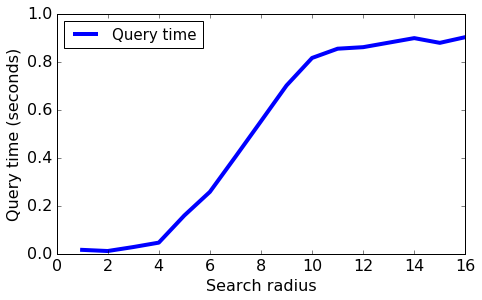

In [40]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Effect of number of random vectors

In [41]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


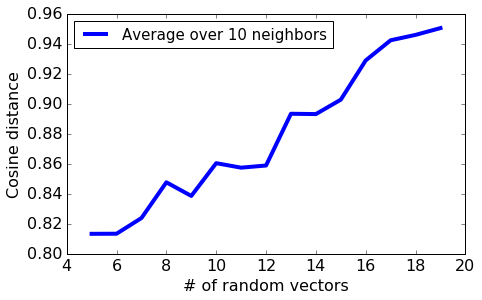

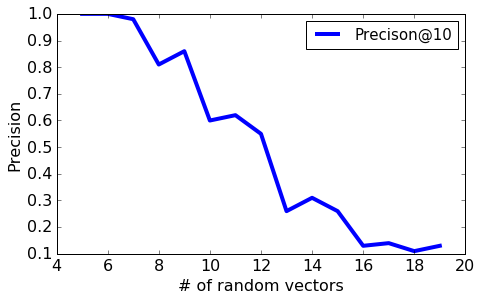

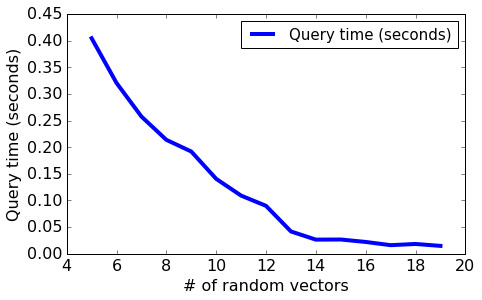

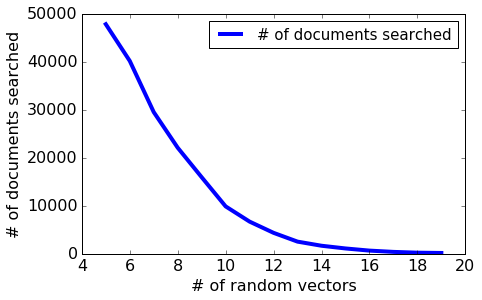

In [42]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()